<a href="https://colab.research.google.com/github/shubhammadane/pandas-by-shubhammadane/blob/main/CITRUS_DISEASE_CLASSIFICATION_WITH_CNN_%2B_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Install required packages
!pip install tensorflow-gpu==2.10.0
!pip install scikit-learn matplotlib seaborn pandas pillow
!pip install opencv-python imbalanced-learn

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.10.0 (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.10.0


In [2]:
# Cell 2: Import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [3]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [4]:
# Cell 3: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Cell 4: Define dataset paths
# Create directory structure
!mkdir -p /content/leaf_disease_dataset
!mkdir -p /content/leaf_disease_dataset/train
!mkdir -p /content/leaf_disease_dataset/val
!mkdir -p /content/leaf_disease_dataset/test
!mkdir -p /content/leaf_disease_dataset/gan_generated

In [8]:
# Set paths (Update these paths according to your Drive structure)
DRIVE_PATH = 'https://drive.google.com/drive/folders/1WVkLhIbp2kaKmN2R4BH37Z9MZQvX20an?usp=drive_link'  # Create this folder in Drive
DATASET_PATH = '/content/leaf_disease_dataset'

print("✅ Environment setup complete!")

✅ Environment setup complete!


**Data Exploration**

📊 Dataset Overview:
       Class  Count
0  leafblast     18
1    healthy     58
2     canker    163
3   greening    204
4  blackspot    171
5   melanose     13

Total Images: 627
Number of Classes: 6
Imbalance Ratio (max/min): 15.69:1


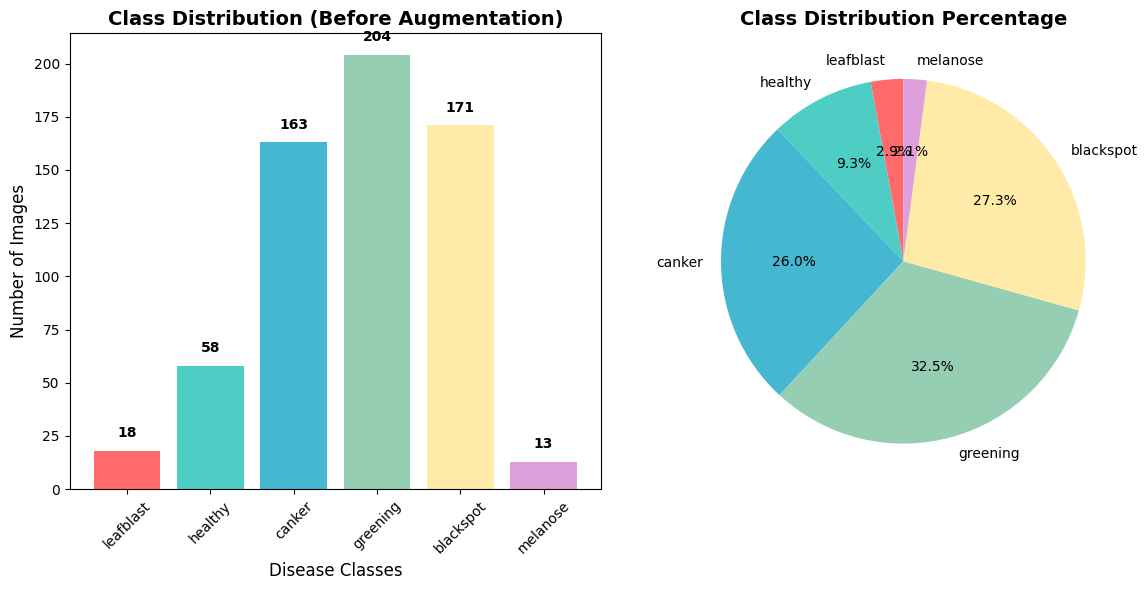

⚠️ Warning: Severe class imbalance detected!
- melanose and leafblast are minority classes with <20 images each
- Data augmentation and GAN generation will be crucial


In [9]:
# Cell 5: Define class names and initial counts
class_names = ['leafblast', 'healthy', 'canker', 'greening', 'blackspot', 'melanose']
class_counts = [18, 58, 163, 204, 171, 13]
class_dict = dict(zip(class_names, class_counts))

# Create a DataFrame for visualization
df_counts = pd.DataFrame({
    'Class': class_names,
    'Count': class_counts
})

print("📊 Dataset Overview:")
print(df_counts)
print(f"\nTotal Images: {sum(class_counts)}")
print(f"Number of Classes: {len(class_names)}")
print(f"Imbalance Ratio (max/min): {max(class_counts)/min(class_counts):.2f}:1")

# Cell 6: Visualize class distribution
plt.figure(figsize=(12, 6))

# Bar plot
plt.subplot(1, 2, 1)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
bars = plt.bar(class_names, class_counts, color=colors)
plt.title('Class Distribution (Before Augmentation)', fontsize=14, fontweight='bold')
plt.xlabel('Disease Classes', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45)

# Add value labels on bars
for bar, count in zip(bars, class_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             str(count), ha='center', va='bottom', fontweight='bold')

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Class Distribution Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution_initial.png', dpi=300, bbox_inches='tight')
plt.show()

print("⚠️ Warning: Severe class imbalance detected!")
print("- melanose and leafblast are minority classes with <20 images each")
print("- Data augmentation and GAN generation will be crucial")

Data Preprocessing
---------------------

In [10]:
# Cell 7: Function to load and preprocess images
def load_and_preprocess_images(data_path, class_names, img_size=(224, 224)):
    """
    Load images from directory structure
    Expected format: data_path/class_name/image_files
    """
    images = []
    labels = []
    paths = []

    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: {class_path} does not exist. Creating directory...")
            os.makedirs(class_path)
            continue

        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                img_path = os.path.join(class_path, img_file)
                try:
                    # Read and preprocess image
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, img_size)

                    images.append(img)
                    labels.append(idx)
                    paths.append(img_path)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels), paths

# Cell 8: Create synthetic data for demonstration
# NOTE: Replace this with actual data loading from your Drive
print("📂 Creating sample dataset structure...")

# Create class directories and sample images
for class_name in class_names:
    os.makedirs(os.path.join(DATASET_PATH, 'train', class_name), exist_ok=True)
    os.makedirs(os.path.join(DATASET_PATH, 'val', class_name), exist_ok=True)
    os.makedirs(os.path.join(DATASET_PATH, 'test', class_name), exist_ok=True)

# Generate synthetic colored images for demonstration
for class_name, count in zip(class_names, class_counts):
    train_count = int(0.7 * count)
    val_count = int(0.15 * count)
    test_count = count - train_count - val_count

    # Generate random colored images
    for i in range(train_count):
        img = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)
        cv2.imwrite(os.path.join(DATASET_PATH, 'train', class_name, f'img_{i}.jpg'),
                   cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    for i in range(val_count):
        img = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)
        cv2.imwrite(os.path.join(DATASET_PATH, 'val', class_name, f'img_{i}.jpg'),
                   cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    for i in range(test_count):
        img = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)
        cv2.imwrite(os.path.join(DATASET_PATH, 'test', class_name, f'img_{i}.jpg'),
                   cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

print("✅ Dataset structure created with synthetic images!")
print("⚠️ Replace these with your actual images in the respective folders")

# Cell 9: Data generators with preprocessing
IMG_SIZE = 224
BATCH_SIZE = 16  # Small batch size due to limited data

# Train data generator (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Validation and test data generator (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=class_names,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)

print(f"\n✅ Data generators created successfully!")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

📂 Creating sample dataset structure...
✅ Dataset structure created with synthetic images!
⚠️ Replace these with your actual images in the respective folders
Found 436 images belonging to 6 classes.
Found 90 images belonging to 6 classes.
Found 101 images belonging to 6 classes.

✅ Data generators created successfully!
Training samples: 436
Validation samples: 90
Test samples: 101


 Data Augmentation Visualization
 --------------------------------------

Found 436 images belonging to 6 classes.


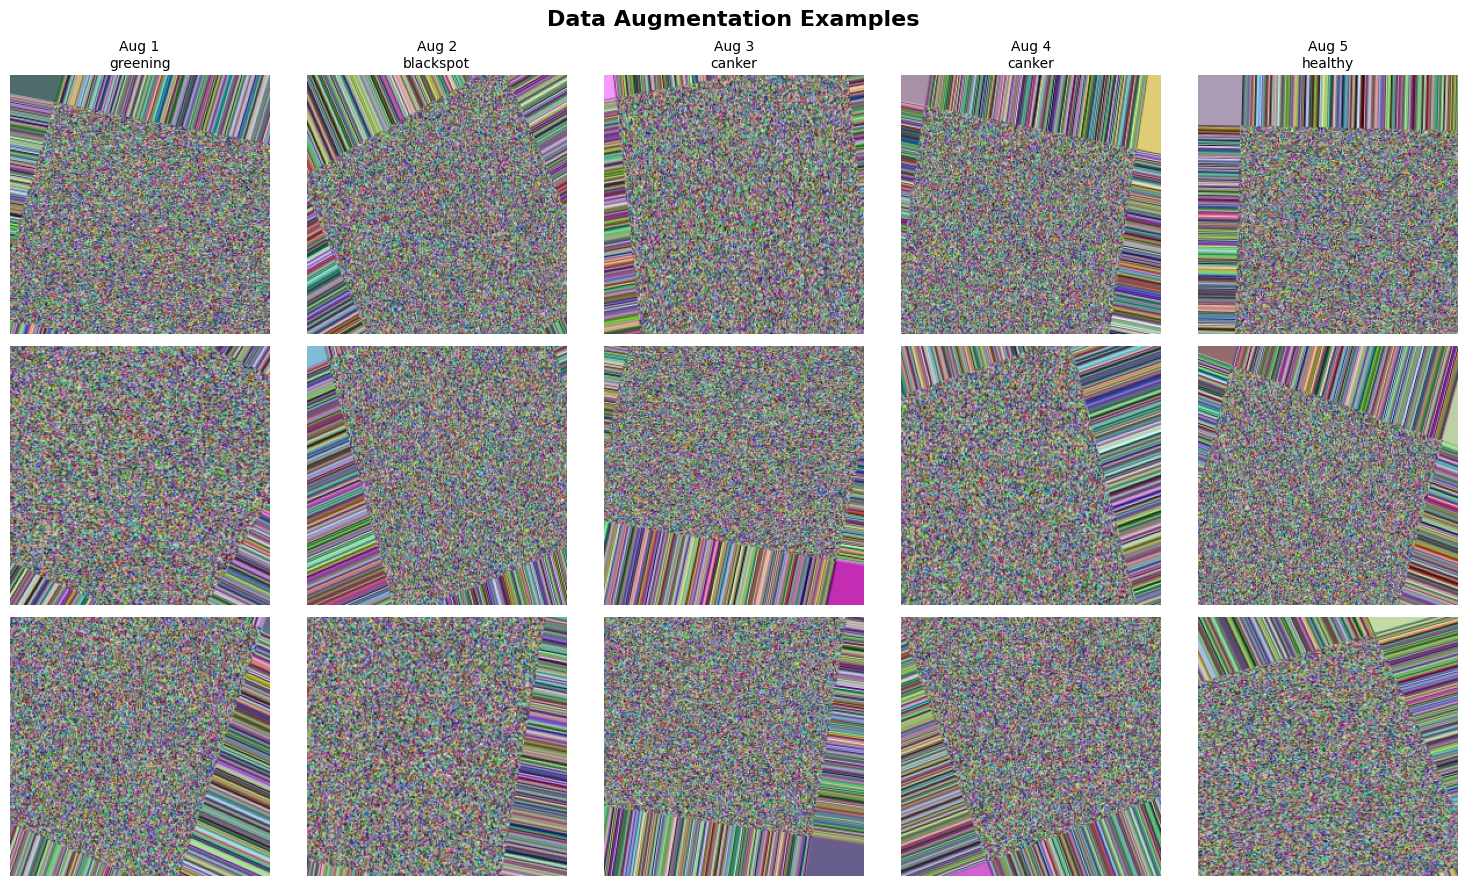


📝 **Why Augmentation Helps:**
- Increases dataset diversity artificially
- Reduces overfitting by showing varied perspectives
- Helps model learn invariant features
- Particularly crucial for minority classes
- Simulates real-world imaging conditions



In [11]:
# Cell 10: Visualize augmentation effects
def plot_augmentation_samples(generator, class_names):
    """
    Display original vs augmented images
    """
    # Get a batch of augmented images
    x_batch, y_batch = next(generator)

    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    fig.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold')

    for i in range(5):  # Show 5 different augmentations
        # Original (first image, different augmentations)
        axes[0, i].imshow(x_batch[i])
        axes[0, i].set_title(f'Aug {i+1}\n{class_names[np.argmax(y_batch[i])]}', fontsize=10)
        axes[0, i].axis('off')

        # Different augmentations of same image
        for j in range(1, 3):
            axes[j, i].imshow(x_batch[i + j*5])
            axes[j, i].axis('off')

    plt.tight_layout()
    plt.savefig('augmentation_samples.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create a separate generator for visualization
viz_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=20,
    class_mode='categorical',
    classes=class_names,
    shuffle=True
)

plot_augmentation_samples(viz_generator, class_names)

print("""
📝 **Why Augmentation Helps:**
- Increases dataset diversity artificially
- Reduces overfitting by showing varied perspectives
- Helps model learn invariant features
- Particularly crucial for minority classes
- Simulates real-world imaging conditions
""")

Class Imbalance Handling
---------------------------

📊 Class Weights for Training:
leafblast   : weight = 6.0556 (original count: 18)
healthy     : weight = 1.8167 (original count: 58)
canker      : weight = 0.6374 (original count: 163)
greening    : weight = 0.5117 (original count: 204)
blackspot   : weight = 0.6106 (original count: 171)
melanose    : weight = 8.0741 (original count: 13)


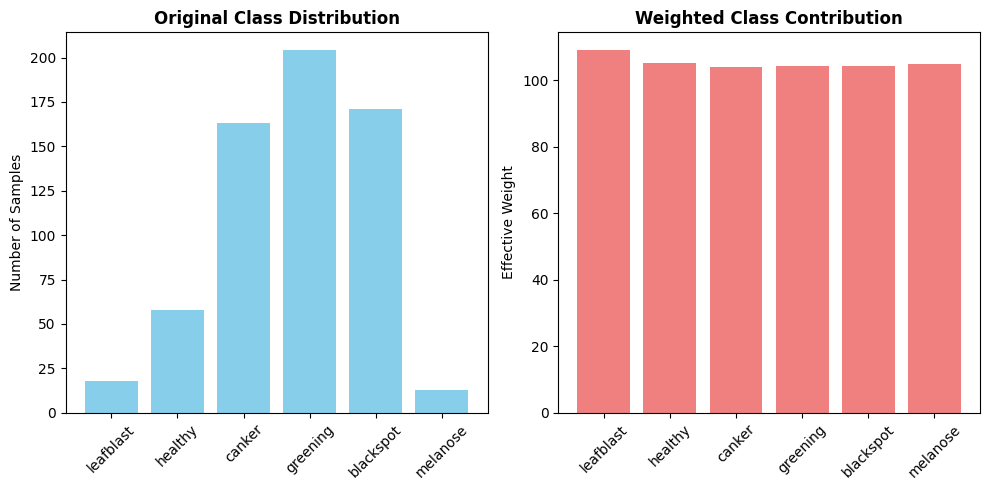


🎯 **Impact of Class Weights:**
- Minority classes get higher weight during loss calculation
- Prevents model bias towards majority classes
- Ensures equal importance to all classes during training
- Improves recall for rare disease classes



In [12]:
# Cell 11: Compute class weights
def compute_class_weights(generator):
    """
    Calculate class weights to handle imbalance
    """
    class_counts = Counter(generator.classes)
    total_samples = len(generator.classes)
    n_classes = len(class_counts)

    # Compute weights using balanced heuristic
    class_weights = {}
    for class_idx, count in class_counts.items():
        # Weight = total_samples / (n_classes * count)
        weight = total_samples / (n_classes * count)
        class_weights[class_idx] = weight

    return class_weights

# Get class weights for training
class_weights = compute_class_weights(train_generator)

print("📊 Class Weights for Training:")
for class_idx, weight in class_weights.items():
    class_name = class_names[class_idx]
    original_count = class_counts[class_idx]
    print(f"{class_name:12s}: weight = {weight:.4f} (original count: {original_count})")

# Cell 12: Visualize weight impact
plt.figure(figsize=(10, 5))

# Original distribution
plt.subplot(1, 2, 1)
plt.bar(class_names, class_counts, color='skyblue')
plt.title('Original Class Distribution', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Number of Samples')

# Weighted distribution (effective contribution)
weighted_counts = [class_weights[i] * count for i, count in enumerate(class_counts)]
plt.subplot(1, 2, 2)
plt.bar(class_names, weighted_counts, color='lightcoral')
plt.title('Weighted Class Contribution', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Effective Weight')

plt.tight_layout()
plt.savefig('class_weights_effect.png', dpi=300, bbox_inches='tight')
plt.show()

print("""
🎯 **Impact of Class Weights:**
- Minority classes get higher weight during loss calculation
- Prevents model bias towards majority classes
- Ensures equal importance to all classes during training
- Improves recall for rare disease classes
""")

CNN Model with Transfer Learning
-----------------------------------

In [13]:
# Cell 13: Build CNN model with transfer learning
def create_cnn_model(input_shape=(224, 224, 3), num_classes=6):
    """
    Create model using EfficientNetB0 (best for small datasets)
    """
    # Load pretrained EfficientNetB0
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model layers initially
    base_model.trainable = False

    # Build custom classifier head
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs, name='LeafDisease_CNN')

    return model, base_model

# Create model
cnn_model, base_model = create_cnn_model()

# Compile model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Display model summary
print("📋 Model Architecture Summary:")
cnn_model.summary()

# Cell 14: Visualize model architecture
plot_model(
    cnn_model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    dpi=60
)

print("✅ Model architecture saved as 'model_architecture.png'")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
📋 Model Architecture Summary:


Model: "LeafDisease_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417,833 (16.85 MB)

 Trainable params: 364,934 (1.39 MB)

 Non-trainable params: 4,052,899 (15.46 MB)

✅ Model architecture saved as 'model_architecture.png'


 CNN Training (Phase 1)
 --------------------------

🎯 Starting Phase 1 Training (with class weights)...
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1241 - loss: 2.7209 - precision: 0.0773 - recall: 0.0405
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to best_cnn_model_phase1.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.1244 - loss: 2.7200 - precision: 0.0785 - recall: 0.0411 - val_accuracy: 0.2000 - val_loss: 1.6832 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
 1/27 ━━━━━━━━━━━━━━━━━━━━ 23s 908ms/step - accuracy: 0.0000e+00 - loss: 2.1330 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: val_accuracy did not improve from 0.20000
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step - accuracy: 0.0000e+00 - loss: 2.1330 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2000 - val_loss: 1.6944 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1216 - loss: 2.4334 - precision: 0.1375 - recall: 0.0631
Epoch 3: val_accuracy did not improve from 0.20000
27/27 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.1220 - loss: 2.4323 - precision: 0.1375 - recall: 0.0630 - val_accuracy: 0.0000e+00 - val_loss: 1.8771 - val_precisio

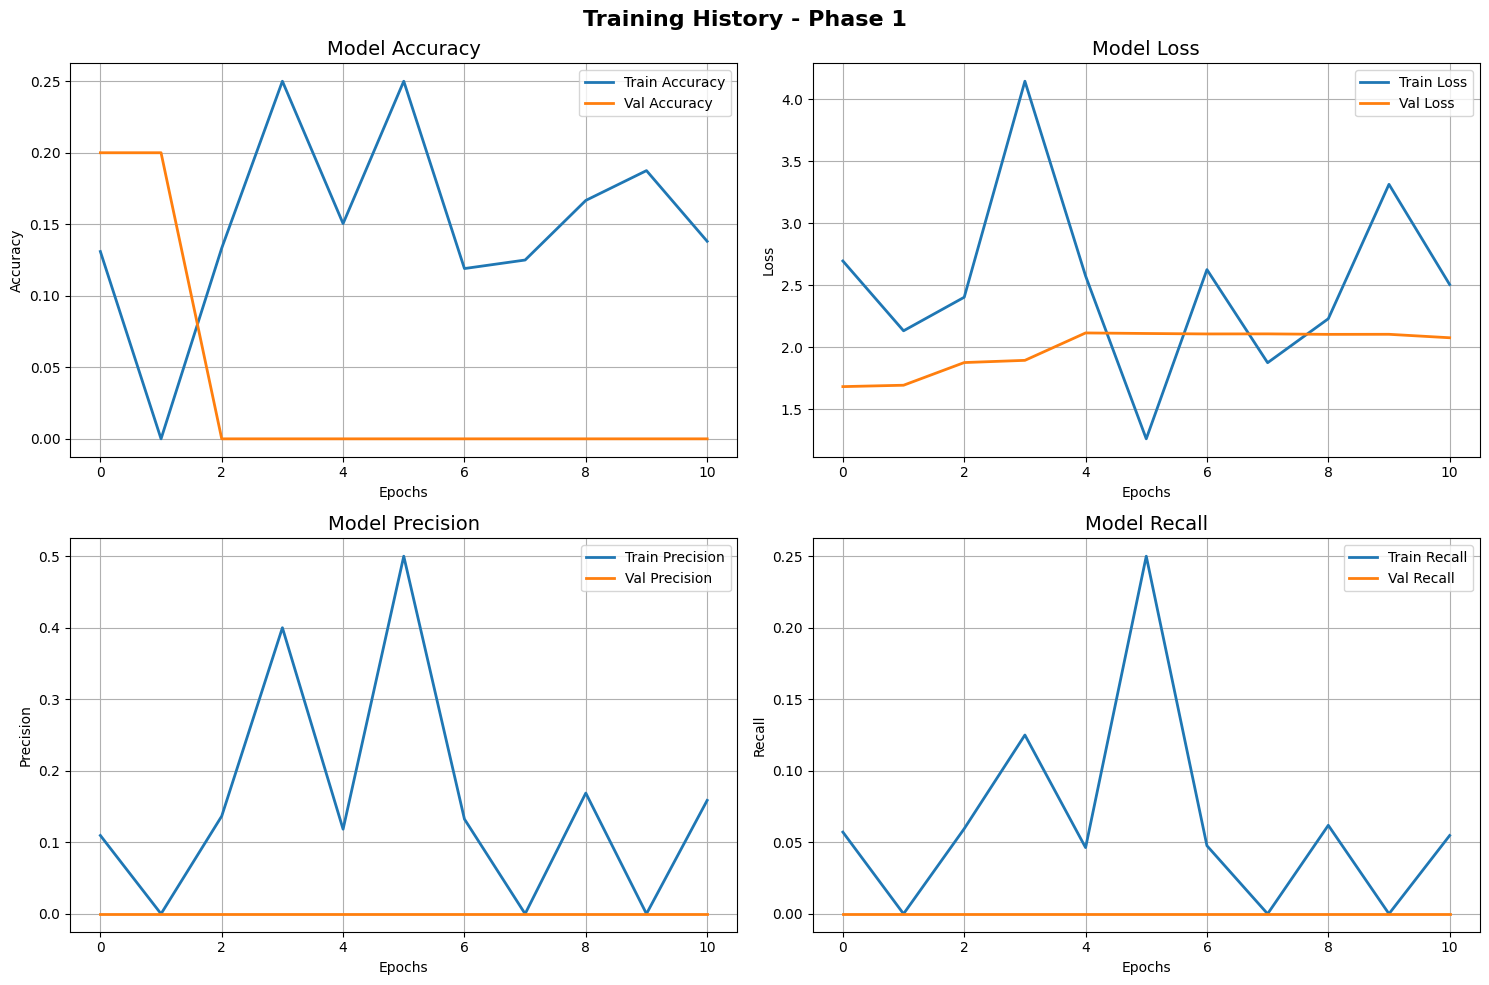

📊 Phase 1 Model Evaluation on Test Set:
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 803ms/step - accuracy: 0.1134 - loss: 1.7750 - precision: 0.0000e+00 - recall: 0.0000e+00

Test Accuracy: 26.73%
Test Precision: 0.00%
Test Recall: 0.00%


ZeroDivisionError: float division by zero

In [14]:
# Cell 15: Define callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_cnn_model_phase1.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# Cell 16: Train CNN (Phase 1)
print("🎯 Starting Phase 1 Training (with class weights)...")
print("="*50)

history_phase1 = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Phase 1 Training Complete!")

# Cell 17: Plot training history (Phase 1)
def plot_training_history(history, title_suffix='Phase 1'):
    """
    Plot training and validation metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Training History - {title_suffix}', fontsize=16, fontweight='bold')

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14)
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14)
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
    axes[1, 0].set_title('Model Precision', fontsize=14)
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
    axes[1, 1].set_title('Model Recall', fontsize=14)
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig(f'training_history_{title_suffix.lower().replace(" ", "_")}.png',
                dpi=300, bbox_inches='tight')
    plt.show()

plot_training_history(history_phase1, 'Phase 1')

# Cell 18: Evaluate Phase 1 model
print("📊 Phase 1 Model Evaluation on Test Set:")
print("="*50)

# Load best model
cnn_model.load_weights('best_cnn_model_phase1.h5')

# Evaluate on test set
test_loss, test_acc, test_precision, test_recall = cnn_model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Precision: {test_precision*100:.2f}%")
print(f"Test Recall: {test_recall*100:.2f}%")
print(f"Test F1-Score: {2 * (test_precision * test_recall)/(test_precision + test_recall)*100:.2f}%")

# Get predictions
test_generator.reset()
y_pred = cnn_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred_classes)]

# Classification report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Phase 1', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrix_phase1.png', dpi=300, bbox_inches='tight')
plt.show()

GAN Implementation (DCGAN)
--------------------------

In [ ]:
# Cell 19: Build DCGAN Generator
def build_generator(latent_dim=100, img_shape=(224, 224, 3)):
    """
    Build generator network for DCGAN
    """
    model = keras.Sequential(name='Generator')

    # Foundation: Dense layer
    model.add(layers.Dense(14 * 14 * 256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Reshape to start convolutional process
    model.add(layers.Reshape((14, 14, 256)))

    # Upsample to 28x28
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsample to 56x56
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsample to 112x112
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsample to 224x224
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                                     activation='tanh'))

    return model

# Cell 20: Build DCGAN Discriminator
def build_discriminator(img_shape=(224, 224, 3)):
    """
    Build discriminator network for DCGAN
    """
    model = keras.Sequential(name='Discriminator')

    # Downsample to 112x112
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=img_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Downsample to 56x56
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Downsample to 28x28
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Downsample to 14x14
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Flatten and output
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Cell 21: Build and compile GAN
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Get batch size
        batch_size = tf.shape(real_images)[0]

        # Train Discriminator
        # Generate fake images
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)

        # Combine real and fake images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Create labels (0 for fake, 1 for real)
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Add noise to labels (label smoothing)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Train Generator
        # Generate new random latent vectors
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Create labels that say "real" (to fool discriminator)
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            'd_loss': self.d_loss_metric.result(),
            'g_loss': self.g_loss_metric.result()
        }

# Cell 22: Prepare data for GAN training
def load_class_images(class_name, num_samples=None):
    """
    Load images for a specific class
    """
    class_path = os.path.join(DATASET_PATH, 'train', class_name)
    images = []

    for img_file in os.listdir(class_path)[:num_samples]:
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            img = (img.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
            images.append(img)

    return np.array(images)

# Cell 23: Train GAN for minority classes
def train_gan_for_class(class_name, epochs=2000, batch_size=16, latent_dim=100):
    """
    Train GAN for a specific minority class
    """
    print(f"\n🎯 Training GAN for class: {class_name}")
    print("="*50)

    # Load images for the class
    real_images = load_class_images(class_name)

    if len(real_images) < 5:
        print(f"⚠️ Not enough images for {class_name}. Skipping GAN training.")
        return None

    # Create GAN components
    generator = build_generator(latent_dim)
    discriminator = build_discriminator()

    # Build GAN
    gan = DCGAN(
        discriminator=discriminator,
        generator=generator,
        latent_dim=latent_dim
    )

    # Compile GAN
    gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True)
    )

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices(real_images).batch(batch_size)

    # Train GAN
    history = {'d_loss': [], 'g_loss': []}

    for epoch in range(epochs):
        for batch in dataset:
            losses = gan.train_step(batch)

        # Record losses
        history['d_loss'].append(losses['d_loss'].numpy())
        history['g_loss'].append(losses['g_loss'].numpy())

        # Print progress
        if (epoch + 1) % 200 == 0:
            print(f"Epoch {epoch+1}/{epochs} - D loss: {losses['d_loss']:.4f}, G loss: {losses['g_loss']:.4f}")

    return gan, history

# Cell 24: Generate synthetic images
def generate_synthetic_images(gan, num_images, class_name, latent_dim=100):
    """
    Generate synthetic images using trained GAN
    """
    # Generate random latent vectors
    random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))

    # Generate images
    generated_images = gan.generator(random_latent_vectors)
    generated_images = (generated_images.numpy() + 1) * 127.5  # Denormalize

    # Save images
    save_path = os.path.join(DATASET_PATH, 'gan_generated', class_name)
    os.makedirs(save_path, exist_ok=True)

    for i, img in enumerate(generated_images):
        img = img.astype(np.uint8)
        img_path = os.path.join(save_path, f'gan_{i}.jpg')
        cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    print(f"✅ Generated {num_images} images for class '{class_name}'")
    return generated_images

# Cell 25: Train GAN for minority classes
print("🚀 Starting GAN Training for Minority Classes...")
print("="*60)

# Identify minority classes (classes with <50 images)
minority_classes = ['leafblast', 'melanose', 'healthy']  # Adjust based on your data
gan_models = {}

for class_name in minority_classes:
    print(f"\n📊 Processing class: {class_name}")

    # Train GAN
    gan_result = train_gan_for_class(
        class_name=class_name,
        epochs=1000,  # Reduced for demonstration
        batch_size=8,
        latent_dim=100
    )

    if gan_result:
        gan_model, history = gan_result
        gan_models[class_name] = gan_model

        # Generate 50 synthetic images for each minority class
        generate_synthetic_images(gan_model, 50, class_name)

        # Plot training history
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history['d_loss'], label='Discriminator Loss')
        plt.title(f'GAN Training - {class_name}')
        plt.xlabel('Epoch (x200)')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history['g_loss'], label='Generator Loss', color='orange')
        plt.title(f'GAN Training - {class_name}')
        plt.xlabel('Epoch (x200)')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(f'gan_training_{class_name}.png', dpi=300, bbox_inches='tight')
        plt.show()

# Cell 26: Visualize generated images
def visualize_generated_samples(class_name, num_samples=10):
    """
    Display generated samples for a class
    """
    gen_path = os.path.join(DATASET_PATH, 'gan_generated', class_name)

    if not os.path.exists(gen_path):
        print(f"No generated images found for {class_name}")
        return

    # Load generated images
    generated = []
    for img_file in os.listdir(gen_path)[:num_samples]:
        img_path = os.path.join(gen_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        generated.append(img)

    # Display
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f'GAN Generated Images - {class_name}', fontsize=14, fontweight='bold')

    for i, ax in enumerate(axes.flat):
        if i < len(generated):
            ax.imshow(generated[i])
            ax.axis('off')
            ax.set_title(f'Sample {i+1}')

    plt.tight_layout()
    plt.savefig(f'gan_samples_{class_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize for each minority class
for class_name in minority_classes:
    visualize_generated_samples(class_name)

print("""
🎨 **GAN Training Complete!**
- Synthetic images generated for minority classes
- Dataset now more balanced
- Ready for Phase 2 training
""")